<a href="https://colab.research.google.com/github/suchisom/Machine-learning-pRak/blob/main/Heart_disease_prediction_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Prediction of Heart Diseases in Patients***
This model find the likelihood of a person having a heart disease using factors such as
age,sex,chest pain type(asymtomatic ***asy*** , ***nap*** non angina, atypical ***ata***), resting bp, cholestrol, fasting bp, resting ECG,
Max hr,exercise angina, oldpeak, slop of peak exercise, heart disease(if yes or no)

# ***Importing all necessary libraries***

We will use a K neighbour classifier for now

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import seaborn as sns

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# Load Dataset

In [ ]:
df = pd.read_csv('heart.csv')
df.head()



,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [ ]:
print(df.dtypes)
df.dtypes.value_counts()


Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object


,count
int64,6
object,5
float64,1


In [ ]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


As we can see the avg age group of people is 53, The minimum cholestrol and resting BP is 0 which is not possible
When the median of a dataset is higher than its mean, it suggests that the distribution of the data might be left-skewed. In a left-skewed distribution, the tail of the distribution is longer on the left side. This means there are likely some lower values that are pulling the mean down more than the median.

The fact that the median is significantly higher than the mean (by roughly 25 mm/dl in this case) strengthens this possibility.

In [ ]:
df.isna().sum()

,0
Age,0
Sex,0
ChestPainType,0
RestingBP,0
Cholesterol,0
FastingBS,0
RestingECG,0
MaxHR,0
ExerciseAngina,0
Oldpeak,0


# ***Categorical Features***
 The df.dtypes.value_counts() output shows that there are 5 columns with the object data type: Sex, ChestPainType, RestingECG, ExerciseAngina, and ST_Slope. These are categorical features that will need to be handled (e.g., using one-hot encoding) before being used in most machine learning models, including the K-Nearest Neighbors classifier you mentioned.

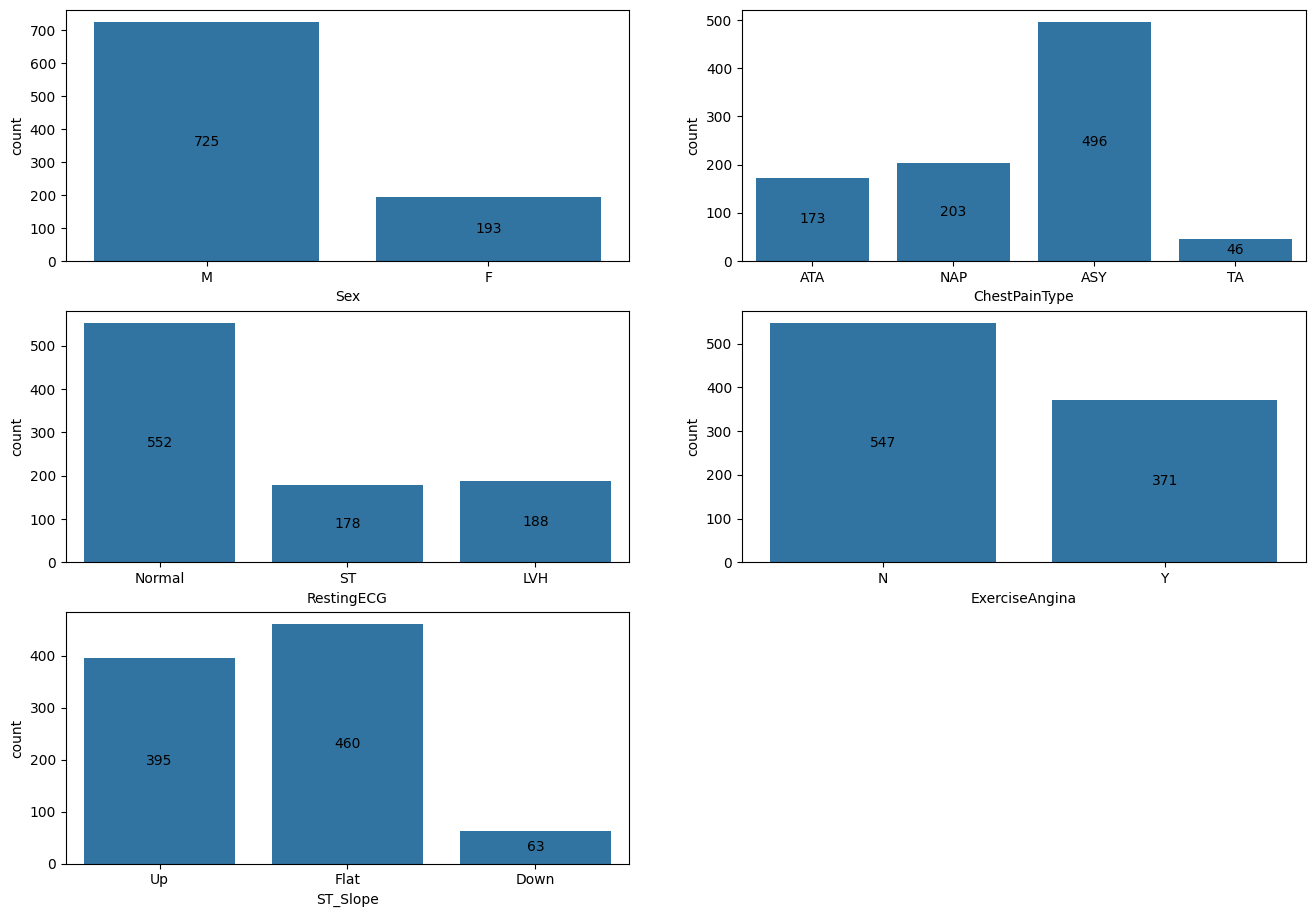

In [ ]:
categorical_cols  = ("Sex","ChestPainType","RestingECG","ExerciseAngina","ST_Slope")
fig = plt.figure(figsize=(16,15))

for idx, col in enumerate(categorical_cols):
    ax = plt.subplot(4, 2, idx+1)
    sns.countplot(x=df[col], ax=ax)
    # add data labels to each bar
    for container in ax.containers:
        ax.bar_label(container, label_type="center")

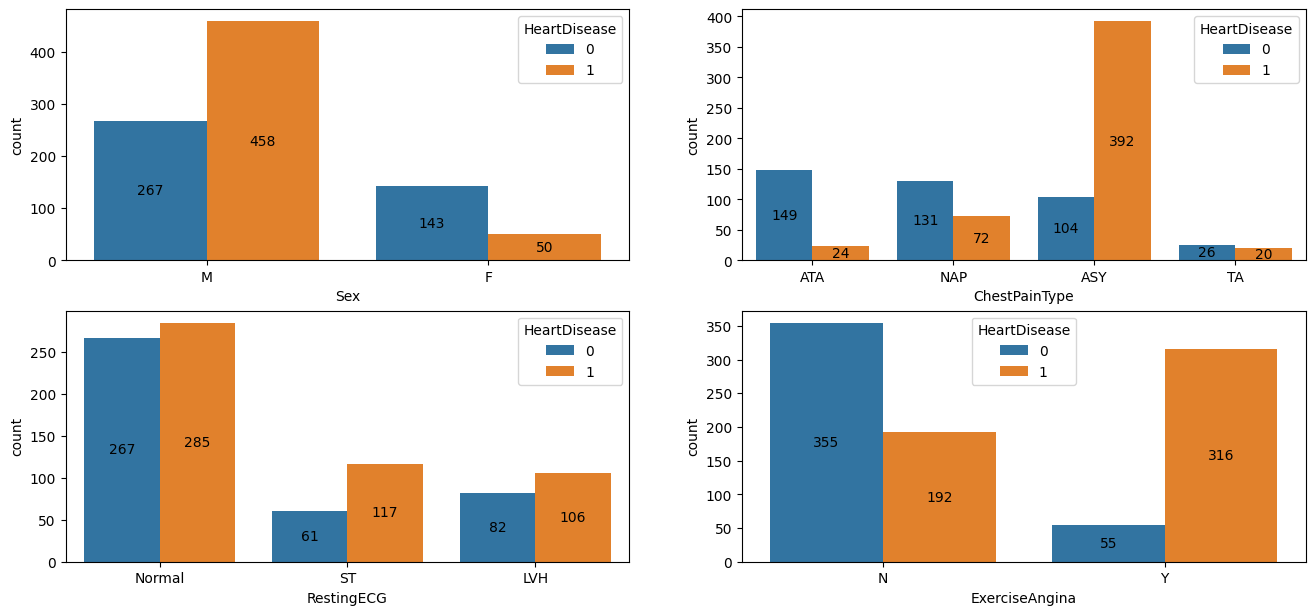

In [ ]:
fig = plt.figure(figsize=(16,15))

for idx, col in enumerate(categorical_cols[:-1]):
    ax = plt.subplot(4, 2, idx+1)
    # group by HeartDisease
    sns.countplot(x=df[col], hue=df["HeartDisease"], ax=ax)
    # add data labels to each bar
    for container in ax.containers:
        ax.bar_label(container, label_type="center")


    We can further notice how skewed the dataset is towards male patients. Only 50 female patients in the dataset have been diagnosed with heart disease.
    A significant number of patients, 392, diagnosed with heart disease have asymptomatic (ASY) chest pain. While chest pain could be a relevant feature for our model, asymptomatic implies that those patients who had a heart disease did not have chest pain as a symptom.
    A high number (170) of patients with blood sugar greater than 120 mg/dl were diagnosed with heart disease in relation to those who were not diagnosed as such.
    Out of all patients who had an exercise-induced angina, 316 were diagnosed with a heart disease.
    Out of all patients with a flat ST slope, 381 were diagnosed with a heart disease.


# Cleaning dataset

As we can observe there is only one row of restingbp which is 0 so we will be dropping that row
but since we cant do the same for cholestrol, we will replace 0 values with the median of non zero values of other patients who have heart disease
***(new_cholestrol value == median(non_zero_patients) && heartdisease == 1)***

In [ ]:
df[df["RestingBP"] == 0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
449,55,M,NAP,0,0,0,Normal,155,N,1.5,Flat,1


In [ ]:
df[df["Cholesterol"] == 0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
293,65,M,ASY,115,0,0,Normal,93,Y,0.0,Flat,1
294,32,M,TA,95,0,1,Normal,127,N,0.7,Up,1
295,61,M,ASY,105,0,1,Normal,110,Y,1.5,Up,1
296,50,M,ASY,145,0,1,Normal,139,Y,0.7,Flat,1
297,57,M,ASY,110,0,1,ST,131,Y,1.4,Up,1
...,...,...,...,...,...,...,...,...,...,...,...,...
514,43,M,ASY,122,0,0,Normal,120,N,0.5,Up,1
515,63,M,NAP,130,0,1,ST,160,N,3.0,Flat,0
518,48,M,NAP,102,0,1,ST,110,Y,1.0,Down,1
535,56,M,ASY,130,0,0,LVH,122,Y,1.0,Flat,1


In [ ]:
df_clean = df.copy()

df_clean =  df_clean[df_clean["RestingBP"] != 0 ]
heartdisease_mask = df_clean["HeartDisease"]==0

cholesterol_without_heartdisease = df_clean.loc[heartdisease_mask, "Cholesterol"]
cholesterol_with_heartdisease = df_clean.loc[~heartdisease_mask, "Cholesterol"]

df_clean.loc[heartdisease_mask, "Cholesterol"] = cholesterol_without_heartdisease.replace(to_replace = 0, value = cholesterol_without_heartdisease.median())
df_clean.loc[~heartdisease_mask, "Cholesterol"] = cholesterol_with_heartdisease.replace(to_replace = 0, value = cholesterol_with_heartdisease.median())


In [ ]:
df_clean[["RestingBP","Cholesterol"]].describe()

,RestingBP,Cholesterol
count,917.000000,917.000000
mean,132.540894,239.700109
std,17.999749,54.352727
min,80.000000,85.000000
25%,120.000000,214.000000
50%,130.000000,225.000000
75%,140.000000,267.000000
max,200.000000,603.000000


Now we will pick features for our model

    Age
    Sex
    ChestPainType
    Cholesterol
    FastingBS


In [ ]:
df_clean = pd.get_dummies(df_clean, drop_first = True)
df_clean.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,True,True,False,False,True,False,False,False,True
1,49,160,180,0,156,1.0,1,False,False,True,False,True,False,False,True,False
2,37,130,283,0,98,0.0,0,True,True,False,False,False,True,False,False,True
3,48,138,214,0,108,1.5,1,False,False,False,False,True,False,True,True,False
4,54,150,195,0,122,0.0,0,True,False,True,False,True,False,False,False,True


We will now find how they are correlated

<Axes: >

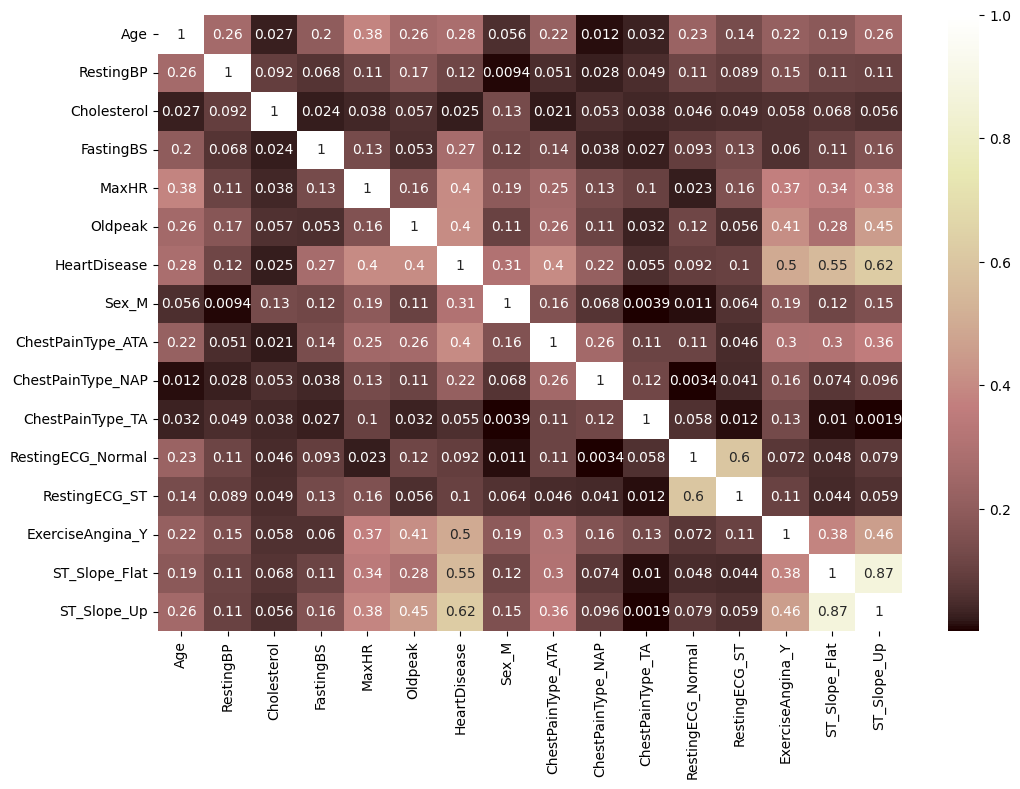

In [ ]:
correlations = abs(df_clean.corr())
plt.figure(figsize=(12,8))
sns.heatmap(correlations, annot=True, cmap="pink")

<Axes: >

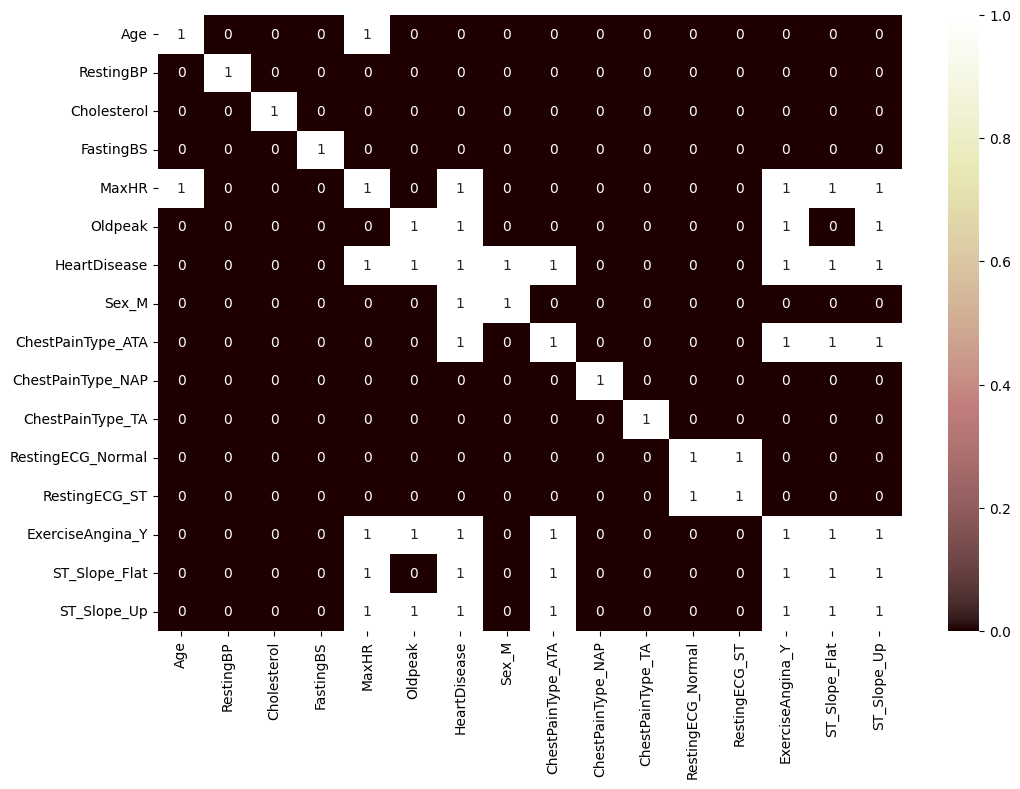

In [ ]:
plt.figure(figsize=(12,8))
sns.heatmap(correlations > 0.3, annot=True, cmap="pink")

# Final List of Features we will use to build our model
This was decided by getting features with correlation higher than 0.3

    Oldpeak
    MaxHR
    ChestPainType_ATA
    ExerciseAngina_Y
    ST_Slope_Flat
    ST_Slope_Up


In [ ]:
X = df_clean.drop(["HeartDisease"], axis = 1)
y = df_clean["HeartDisease"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size= 0.15, random_state = 417)

features = [
    "Oldpeak",
    "Sex_M",
    "ExerciseAngina_Y",
    "ST_Slope_Flat",
    "ST_Slope_Up"
]

In [ ]:
for feature in features:
    knn = KNeighborsClassifier(n_neighbors = 3)
    knn.fit(X_train[[feature]], y_train)
    accuracy = knn.score(X_val[[feature]], y_val)
    print(f"The k-NN classifier trained on {feature} and with k = 3 has an accuracy of {accuracy*100:.2f}%")

The k-NN classifier trained on Oldpeak and with k = 3 has an accuracy of 76.81%
The k-NN classifier trained on Sex_M and with k = 3 has an accuracy of 44.93%
The k-NN classifier trained on ExerciseAngina_Y and with k = 3 has an accuracy of 73.19%
The k-NN classifier trained on ST_Slope_Flat and with k = 3 has an accuracy of 81.88%
The k-NN classifier trained on ST_Slope_Up and with k = 3 has an accuracy of 84.06%


In [ ]:
#normalising data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train[features])
X_val_scaled = scaler.transform(X_val[features])

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train_scaled, y_train)
accuracy = knn.score(X_val_scaled, y_val)
print(f"Accuracy: {accuracy*100:.2f}")

Accuracy: 86.23


In [ ]:
X = df_clean.drop(["HeartDisease"], axis=1)
y = df_clean["HeartDisease"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state = 417)

features = [
    "Oldpeak",
    "Sex_M",
    "ExerciseAngina_Y",
    "ST_Slope_Flat",
    "ST_Slope_Up"
]

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train[features])
X_test_scaled = scaler.transform(X_test[features])

In [ ]:
grid_params = {"n_neighbors": range(1, 20),
                "metric": ["minkowski", "manhattan"]
              }

knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn, grid_params, scoring='accuracy')
knn_grid.fit(X_train_scaled, y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'metric': ['minkowski', 'manhattan'],
                         'n_neighbors': range(1, 20)},
             scoring='accuracy')

In [ ]:
knn_grid.best_score_*100, knn_grid.best_params_

(np.float64(83.56327543424318), {'metric': 'minkowski', 'n_neighbors': 19})

In [ ]:
X_test_scaled = scaler.transform(X_test[features])
predictions = knn_grid.best_estimator_.predict(X_test_scaled)
accuracy = accuracy_score(y_test, predictions)
print(f" Model Accuracy on test set: {accuracy*100:.2f}")

 Model Accuracy on test set: 86.23


In [ ]:
print("Distribution of patients by their sex in the entire dataset")
print(X.Sex_M.value_counts())

print("\nDistribution of patients by their sex in the training dataset")
print(X_train.Sex_M.value_counts())

print("\nDistribution of patients by their sex in the test dataset")
print(X_test.Sex_M.value_counts())

Distribution of patients by their sex in the entire dataset
Sex_M
True     724
False    193
Name: count, dtype: int64

Distribution of patients by their sex in the training dataset
Sex_M
True     615
False    164
Name: count, dtype: int64

Distribution of patients by their sex in the test dataset
Sex_M
True     109
False     29
Name: count, dtype: int64


In [ ]:
# Initialize and train the SVM classifier
svm_model = SVC(random_state=42) # You can adjust parameters later for tuning
svm_model.fit(X_train_scaled, y_train)

# Make predictions on the scaled test set
svm_predictions = svm_model.predict(X_test_scaled)

# Evaluate the SVM model
svm_accuracy = accuracy_score(y_test, svm_predictions)
print(f"SVM Model Accuracy on test set: {svm_accuracy*100:.2f}%")

# Print classification report and confusion matrix for SVM
print("\nSVM Classification Report:")
print(classification_report(y_test, svm_predictions))

print("\nSVM Confusion Matrix:")
print(confusion_matrix(y_test, svm_predictions))

SVM Model Accuracy on test set: 84.78%

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.84      0.83        62
           1       0.87      0.86      0.86        76

    accuracy                           0.85       138
   macro avg       0.85      0.85      0.85       138
weighted avg       0.85      0.85      0.85       138


SVM Confusion Matrix:
[[52 10]
 [11 65]]


## ***Decision Tree***

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

# Initialize and train the Decision Tree classifier
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_scaled, y_train)

# Make predictions on the scaled test set
dt_predictions = dt_model.predict(X_test_scaled)

# Evaluate the Decision Tree model
dt_accuracy = accuracy_score(y_test, dt_predictions)
print(f"Decision Tree Model Accuracy on test set: {dt_accuracy*100:.2f}%")

# Print classification report and confusion matrix for Decision Tree
print("\nDecision Tree Classification Report:")
print(classification_report(y_test, dt_predictions))

print("\nDecision Tree Confusion Matrix:")
print(confusion_matrix(y_test, dt_predictions))

Decision Tree Model Accuracy on test set: 84.78%

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.85      0.83        62
           1       0.88      0.84      0.86        76

    accuracy                           0.85       138
   macro avg       0.85      0.85      0.85       138
weighted avg       0.85      0.85      0.85       138


Decision Tree Confusion Matrix:
[[53  9]
 [12 64]]


# ***A custom function for singular input***

In [ ]:
def predict_heart_disease(customer_data, model, scaler, features):
    """
    Predicts the likelihood of heart disease for a single customer.

    Args:
        customer_data (dict): A dictionary containing the customer's feature values.
                              Keys should match the original DataFrame column names.
        model: The trained machine learning model (e.g., svm_model).
        scaler: The fitted scaler used for preprocessing the training data.
        features (list): A list of the feature names used for training the model.

    Returns:
        int: The predicted class (0 for no heart disease, 1 for heart disease).
    """
    # Create a pandas DataFrame from the customer data
    customer_df = pd.DataFrame([customer_data])

    # Apply one-hot encoding to categorical features (matching the training data)
    # Need to ensure all possible categories from the original data are considered
    # to avoid errors if a category is missing in the customer_data
    categorical_cols = ["Sex","ChestPainType","RestingECG","ExerciseAngina","ST_Slope"] # Based on your original categorical columns
    customer_df = pd.get_dummies(customer_df, columns=categorical_cols, drop_first=True)

    # Ensure all feature columns used in training are present, fill missing with 0
    # This is crucial because get_dummies might not create columns for categories
    # not present in the single customer's data.
    for feature in features:
        if feature not in customer_df.columns:
            customer_df[feature] = 0

    # Select and reorder columns to match the features used during training
    customer_df_selected = customer_df[features]

    # Scale the selected features using the *same* scaler fitted on the training data
    customer_scaled = scaler.transform(customer_df_selected)

    # Make the prediction
    prediction = model.predict(customer_scaled)

    return prediction[0]

In [ ]:
# Example usage of the function (you'll need to replace with actual customer data)
# Note: The dictionary keys should match the original column names before one-hot encoding
# You'll also need to provide values for the other columns that were used in get_dummies
# even if they were later dropped based on correlation, as get_dummies needs them.

# Example customer data (replace with real values for a customer)
# You need to include all original categorical columns here even if not in the final features list
sample_customer_data = {
    "Age": 19,
    "Sex": "M", # "M" or "F"
    "ChestPainType": "NAP", # "ATA", "NAP", "ASY", "TA"
    "RestingBP": 90,
    "Cholesterol": 40,
    "FastingBS": 0, # 0 or 1
    "RestingECG": "Normal", # "Normal", "ST", "LVH"
    "MaxHR": 40,
    "ExerciseAngina": "N", # "Y" or "N"
    "Oldpeak": 1.0,
    "ST_Slope": "Flat", # "Up", "Flat", "Down"
    "HeartDisease": 0 # This won't be used for prediction, but needed for structure if coming from original data
}


# Make a prediction using the trained SVM model, scaler, and selected features
# Ensure svm_model, scaler, and features variables are available from previous cells
predicted_class = predict_heart_disease(sample_customer_data, svm_model, scaler, features)

if predicted_class == 1:
    print("The model predicts that this customer is likely to have heart disease.")
else:
    print("The model predicts that this customer is likely not to have heart disease.")

The model predicts that this customer is likely to have heart disease.


# ***Logistic Regression***

In [ ]:
# Initialize and train the Logistic Regression classifier
# Using a solver that works well with scaled data
lr_model = LogisticRegression(random_state=42, solver='liblinear')
lr_model.fit(X_train_scaled, y_train)

# Make predictions on the scaled test set
lr_predictions = lr_model.predict(X_test_scaled)

# Evaluate the Logistic Regression model
lr_accuracy = accuracy_score(y_test, lr_predictions)
print(f"Logistic Regression Model Accuracy on test set: {lr_accuracy*100:.2f}%")

# Print classification report and confusion matrix for Logistic Regression
print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, lr_predictions))

print("\nLogistic Regression Confusion Matrix:")
print(confusion_matrix(y_test, lr_predictions))

Logistic Regression Model Accuracy on test set: 84.06%

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.82      0.82        62
           1       0.86      0.86      0.86        76

    accuracy                           0.84       138
   macro avg       0.84      0.84      0.84       138
weighted avg       0.84      0.84      0.84       138


Logistic Regression Confusion Matrix:
[[51 11]
 [11 65]]


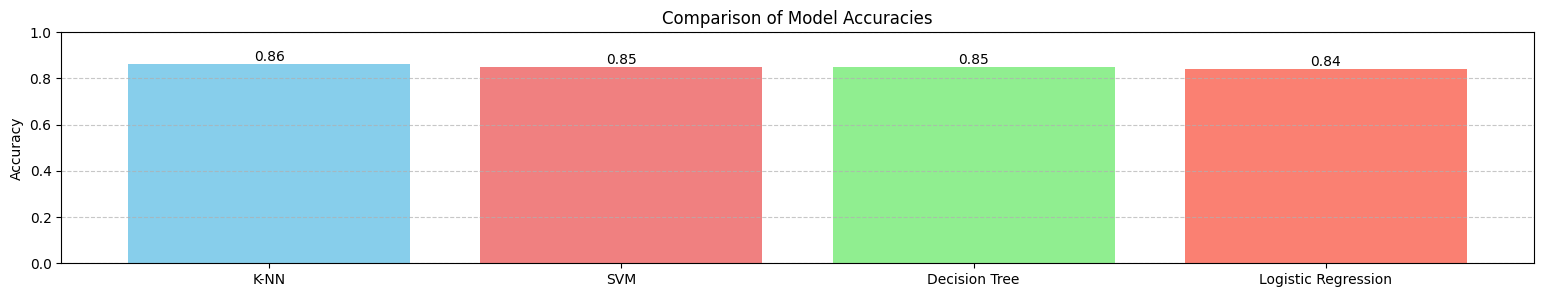

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have the accuracy scores for KNN, SVM, Decision Tree, and Logistic Regression
# Replace with your actual accuracy variables if they are different
knn_accuracy = 0.8623  # From your previous KNN evaluation
svm_accuracy = svm_accuracy # From the SVM evaluation cell
dt_accuracy = dt_accuracy # From the Decision Tree evaluation cell
lr_accuracy = lr_accuracy # From the Logistic Regression evaluation cell

models = ['K-NN', 'SVM', 'Decision Tree', 'Logistic Regression']
accuracies = [knn_accuracy, svm_accuracy, dt_accuracy, lr_accuracy]

plt.figure(figsize=(19, 3))
bars = plt.bar(models, accuracies, color=['skyblue', 'lightcoral', 'lightgreen', 'salmon'])

plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies')
plt.ylim(0, 1) # Set y-axis limit to 0-1 for accuracy
plt.grid(axis='y', linestyle='--', alpha=0.7) # Add horizontal grid lines

# Add accuracy values on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2f}', va='bottom', ha='center') # va: vertical alignment, ha: horizontal alignment


plt.show()

In [7]:
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
texlive-fonts-recommended is already the newest version (2021.20220204-1).
texlive-plain-generic is already the newest version (2021.20220204-1).
texlive-xetex is already the newest version (2021.20220204-1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [11]:
!jupyter nbconvert --to html /content/Heart_disease_prediction_.ipynb

[NbConvertApp] Converting notebook /content/Heart_disease_prediction_.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 5 image(s).
[NbConvertApp] Writing 970335 bytes to /content/Heart_disease_prediction_.html
